# Explainable AI Notebook

## Imports

In [7]:
# Set root directory of the project as the current working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    %cd ..


import logging
logging.getLogger().setLevel(logging.WARNING)


In [8]:
sys.path

['/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python311.zip',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/lib-dynload',
 '',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/setuptools/_vendor',
 '/Users/johannesherstad']

In [9]:
# Standard libraries
import random

# Third-party libraries
import mat4py as mpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import os

# Keras Tuner
import kerastuner as kt



# Custom modules 
from src.models import load_preprocessed_data, load_saved_model
from src.evaluation import evaluate_regression_model, plot_true_vs_pred
from config.defaults import Config

config = Config()

## Data loading

In [10]:
# Load preprocessed data

# Regression
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(model_task = "regression" , eol_capacity=config.eol_capacity)

# Classification
X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, metadata = load_preprocessed_data(model_task = "classification" , eol_capacity=config.eol_capacity)


## Load and Evaluate models

### Regression

#### LSTM

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6052e-04 - mae: 0.0220 


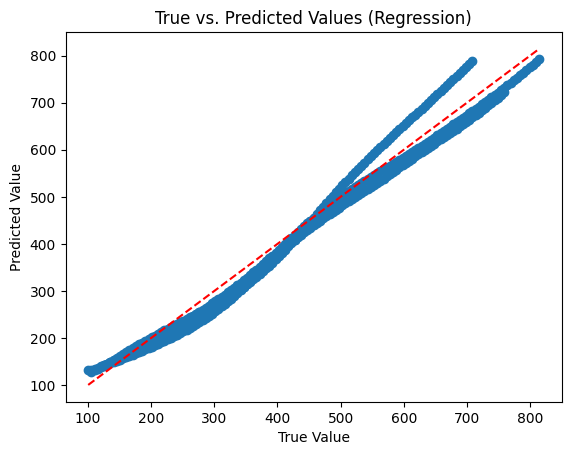

In [11]:
# 1) Load the model
lstm_model = load_saved_model(model_task = "lstm_regression", config=config)

# 2) Generate predictions
y_pred = lstm_model.predict(X_test)

# 3) Evaluate (for example, if your evaluate_regression_model only needs X_test, y_test)
test_loss, mae_rescaled = evaluate_regression_model(
    model=lstm_model, 
    X_test=X_test, 
    y_test=y_test_reg, 
    y_max=metadata["y_max"]
)

# 4) Plot
plot_true_vs_pred(y_test_reg, y_pred, y_max=metadata["y_max"])


#### Interpretable Alternative

### Classification

#### 1D Convolutional Neural Network

#### Decision Tree

#### Logistic regression

## Ante-Hoc Explainability Methods

### SHAP

#### Regression

#### Classification

### TimeSHAP

In [ ]:
from src.TimeSHAP import (
    avg_rul,  get_sequence,
    local_event_explainer, plot_local_event_explanation,
    compute_global_explanation, plot_event_explanation,
)

#### Regression

In [ ]:
TimeSHAP_n_samples = 1000

f = lambda x: lstm_model.predict(x)

X_train.shape

prun_dict = {'tol': 0.05}

# Select a random test sequence
seq_idx = np.random.randint(0, len(X_test))

seq_idx

In [ ]:
# 1) Compute the baseline sequence
data_2d = X_train.squeeze(axis=-1)            # (n_samples, 120)
mean_per_timestep = np.mean(data_2d, axis=0)  # (120,)
baseline_sequence = mean_per_timestep.reshape(120, 1)

# 2) Get a single test sequence (1, 120, 1)
test_sequence = get_sequence(X_test, 1)

# 3) Reshape baseline to match
baseline_sequence = baseline_sequence.reshape(1, 120, 1)

# 4) Compute local event explanation
event_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# Plot the event explanation.
plot_local_event_explanation(event_explanation)


In [ ]:
# 1) Copy the original sequence
modified_sequence = test_sequence.copy()

# 2) Apply a nonlinear decay multiplier from timestep 100 onward.
# The multiplier will start at 1.0 at timestep 100 and drop to 0.9 at the last timestep,
# but with an exponent greater than 1 so the drop is minimal initially and then accelerates.
seq_length = test_sequence.shape[1]  # total timesteps, e.g., 120
if seq_length > 100:
    T = seq_length - 100               # number of timesteps to modify
    p = 2                              # exponent > 1 for accelerating decay later
    indices = np.arange(T)             # indices 0, 1, ..., T-1
    # Compute multipliers: at index 0, multiplier = 1.0; at index T-1, multiplier = 0.9.
    multipliers = 1 - 0.1 * (indices / (T - 1))**p
    modified_sequence[0, 100:, 0] *= multipliers

# 3) Compare predictions
original_pred = f(test_sequence)       # Prediction from original sequence
modified_pred = f(modified_sequence)   # Prediction from modified sequence

print("Original prediction:", original_pred)
print("Modified prediction:", modified_pred)

# 4) Run local explanations for both sequences
original_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

modified_explanation = local_event_explainer(
    f, 
    modified_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# 5) Plot the local event explanations for comparison
fig_original = plot_local_event_explanation(original_explanation)
fig_original.show()

fig_modified = plot_local_event_explanation(modified_explanation)
fig_modified.show()


In [ ]:
# X_test_lstm has shape (n_samples, 120, 1)
# average_event is also length 120 (shape (120,1)) from earlier

# 1) We do NOT need to filter out zero-padding or check for >=100 non-zero steps

# 2) We do NOT trim anything, because each sequence is already 120 timesteps

# final_sequences has the same shape as X_test_lstm
final_sequences = X_test

# 3) The baseline is just your average_event, reshaped if needed
baseline_event = baseline_sequence.reshape(1, 120, 1)  # shape (1,120,1)

# 4) Call compute_event_explanation on all sequences
global_explanation = compute_global_explanation(
    f,
    final_sequences,
    baseline=baseline_event,
    random_seed=42,  # or whatever random state
    nsamples=2000,
    verbose=False,
    absolute=True
)

print(global_explanation.shape)  # check the resulting DataFrame


In [ ]:
global_event_chart = plot_event_explanation(global_explanation, relative=False)
global_event_chart.show()

# Take the absolute value of the event_data_bin DataFrame
global_explanation_abs = global_explanation.abs()

global_event_chart_abs = plot_event_explanation(global_explanation_abs, relative=False)
global_event_chart_abs.show()

#### Classification

### Grad-CAM

#### Regression

#### Classification

## Quantitative XAI Evaluation

In this section, we will evaluate the performance of the different XAI methods on the regression and classification tasks.

We will use the following metrics:
* Faithfulness
    * PGI (Prediction-Guided Importance)
    * PGU (Prediction-Guided Unimportance)
*
    


### Faithfulness

Faithfulness is the degree to which the explanation is faithful to the model. It is measured by the correlation between the explanation and the model's prediction.

Through the metrics PGI (Prediction-Guided Importance) and PGU (Prediction-Guided Unimportance), we can measure the faithfulness of the explanation, by perturbing the timesteps deemed most and least important by the XAI methods, and measuring the change in the prediction.

The intuition is that if the XAI method is faithful, perturbing the timesteps deemed most important should have a greater impact on the prediction than perturbing the timesteps deemed least important.

In [ ]:
# Identify the most important timesteps from the results of the Explainable AI techniques.
# The result for each technique is a sorted list, containing the indices of the most important timesteps from least to most important.

# LSTM SHAP

# LSTM TimeSHAP

# 1D-CNN SHAP

# 1D-CNN TimeSHAP

# 1D-CNN GradCAM

In [ ]:
# Perturbation function

def perturbation_function(x, feature_importance_indices):
    # Recieve a list of indices of either the most or the least important timesteps
    # Perturb the values of these timesteps by adding noise to them
    # Return the perturbed input

    x_perturbed = x.copy()
    for idx in feature_importance_indices:
        noise = np.random.normal(loc=0, scale=0.5)
        x_perturbed[idx] = x_perturbed[idx] + noise
    return x_perturbed


In [ ]:
# PGI AND PGU calculation function

def compute_pgi_pgu(model, x, importance_scores, K, runs=10):
    # Compute the PGI and PGU scores for the input x
    # K is the number of timesteps to perturb
    # Runs is the number of times to run the perturbation, to get a more stable estimate
    # Return the PGI and PGU scores

    pgi_scores = []
    pgu_scores = []
    pg_random_scores = []

        # Get the indices of the most important timesteps

    K_most_important = importance_scores[:K]
    print(f"K_most_important: {K_most_important}")
    K_least_important = importance_scores[-K:]
    print(f"K_least_important: {K_least_important}")

    print(x.shape)


    for i in range(runs):
        # Perturb the input for the most important timesteps
        x_perturbed_PGI = perturbation_function(x, K_most_important)

        #print(x_perturbed_PGI)

        # Perturb the input for the least important timesteps
        x_perturbed_PGU = perturbation_function(x, K_least_important)

        # Perturb the input for random timesteps
        random_indices = random.sample(range(120), K)
        x_perturbed_random = perturbation_function(x, random_indices)

        

        # Get the prediction for the original input
        original_prediction = model.predict(x)

        # Get the prediction for the perturbed input for the most important timesteps
        prediction_PGI = model.predict(x_perturbed_PGI)

        # Get the prediction for the perturbed input for the least important timesteps
        prediction_PGU = model.predict(x_perturbed_PGU)

        # Get the prediction for the perturbed input for random timesteps
        prediction_random = model.predict(x_perturbed_random)

        print(f"Original prediction: {original_prediction}")
        print(f"Prediction PGI: {prediction_PGI}")
        print(f"Prediction PGU: {prediction_PGU}")
        print(f"Prediction Random: {prediction_random}")

        # Compute the PGI and PGU scores
        pgi = np.linalg.norm(original_prediction - prediction_PGI)
        pgu = np.linalg.norm(original_prediction - prediction_PGU)
        pg_random = np.linalg.norm(original_prediction - prediction_random)

        pgi_scores.append(pgi)
        pgu_scores.append(pgu)
        pg_random_scores.append(pg_random)

        print(f"Run {i+1}: PGI = {pgi}, PGU = {pgu}, PG_Random = {pg_random}")

    return np.mean(pgi_scores), np.mean(pgu_scores), np.mean(pg_random_scores)


In [ ]:
global_explanation

In [ ]:
# Sort the global_explanation DataFrame by the values of the importance scores (Average Shapley values)

global_explanation_sorted = global_explanation.sort_values(by="Average Shapley Value", ascending=False)
global_explanation_sorted["Event Number"]



In [ ]:
pgi_scores, pgu_scores, pg_random_scores = compute_pgi_pgu(lstm_model, X_test, global_explanation_sorted["Event Number"]
, K=10, runs=20)

In [ ]:
print(pgi_scores, pgu_scores, pg_random_scores)